# Make Wavelength bins

- author  :Sylvie Dagoret-Campagne
- affiliaiton : IJCLab/IN2P3/CNRS
- creation date : April 24th 2020
- Last veryfication : December 14th 2021


Use very standard atmospheric profile with:

- no aerosol
- 300 DU of Ozone
- PWV = 4 mm
- no cloud


- Input : libradtran atmospheric profile in **RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT**

- Output : the wavelength tables in files **WaveLengthBins.csv**, **WaveLengthBins.fits**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

import matplotlib.cm as cm
import matplotlib as mpl
cmap = cm.jet

import pysynphot as S
from scipy.interpolate import interp1d
import astropy.units as u
from astropy import constants as const
from astropy.io import fits

from astropy.table import Table

PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
PATH_ATMDATA="RT_MPL_pp_us_sa_rtvis_z10_wv40_oz30_cld0000.OUT"

sys.path.append(PATH_LSSTFiltersKG)
sys.path.append(PATH_ATMDATA)


import libLSSTFiltersKG as lsst

liblsstfilter_path= /Users/sylvie/MacOSX/GitHub/LSST/PhotomCorrectAuxTel/tools/MakeWavelengthBins/../../data/lsst/LSSTFiltersKG


In [4]:
##----

NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0                      # LSST Exposure time

#------------------------------------------------------------------------------------------
#  Compute the multiplicative factor as calcilated for SpectractorSim to be used for AuxTel
#-------------------------------------------------------------------------------------------
Tel_Surf=LSST_COLL_SURF*(u.cm)**2            # collection surface of telescope
Time_unit=1*u.s                              # flux for 1 second
SED_unit=1*u.erg/u.s/(u.cm)**2/(u.nanometer) # Units of SEDs in flam (erg/s/cm2/nm)
hc=const.h*const.c                           # h.c product of fontamental constants c and h 
wl_dwl_unit=(u.nanometer)**2                 # lambda.dlambda  in wavelength in nm
g_elec=3.0                                   # electronic gain : elec/ADU
g_disperser_ronchi=0.2                       # theoretical gain for order+1 : 20%
#Factor=2.1350444e11
Factor=(Tel_Surf*SED_unit*Time_unit*wl_dwl_unit/hc/g_elec*g_disperser_ronchi).decompose()
#-------------------------------------------------------------------------------------------------

graphtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /Users/sylvie/MacOSX/External/PySynPhotData/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 350000.0
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [5]:
file_out_basename="WaveLengthBins"

# Start

In [6]:
# power law
#-----------
#plt.figure()
#pl = S.PowerLaw(10000, -2,waveunits='Angstrom',fluxunits='flam')
#plt.loglog(pl.wave, pl.flux)
#plt.axvline(10000, ls='--', color='k')
#plt.axhline(1, ls='--', color='k')
#plt.xlabel(pl.waveunits)
#plt.ylabel(pl.fluxunits)
#plt.title(pl.name)
#plt.show()

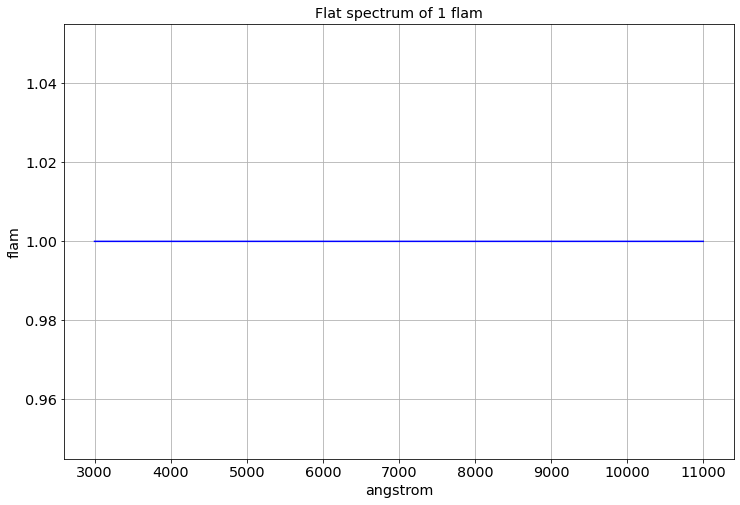

In [7]:
# 1) get a typical spectrum in flam unit (erg/sec/cm)
#-----------------------------------------------------
plt.figure()
flatsp = S.FlatSpectrum(1, fluxunits='flam')
plt.plot(flatsp.wave, flatsp.flux,'b-')
plt.xlabel(flatsp.waveunits)
plt.ylabel(flatsp.fluxunits)
plt.title(flatsp.name)
plt.grid()
plt.show()
    

/Users/sylvie/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


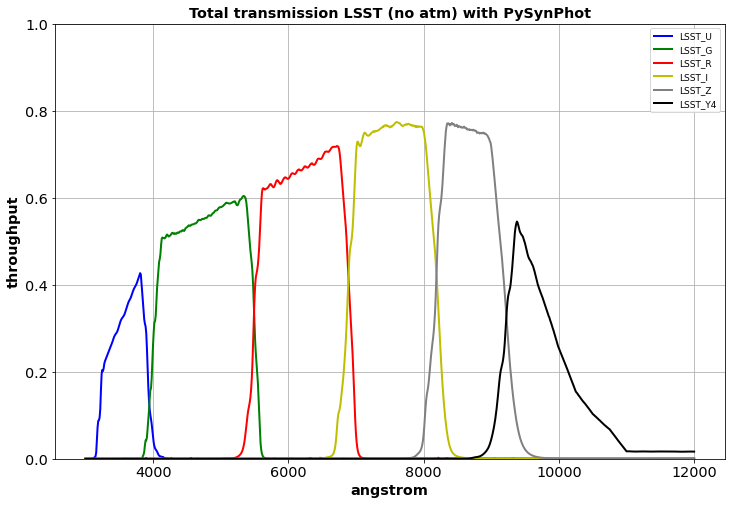

In [8]:
#  2) Read LSST passband in Angstrom
#-------------------------------------------------------
bp_u,bp_g,bp_r,bp_i,bp_z,bp_y=lsst.GetAllLSSTBands("../../data/lsst")
lsst.PlotAllLSSTBands(bp_u,bp_g,bp_r,bp_i,bp_z,bp_y)

## Get atmosphere

In [9]:
data=np.loadtxt(PATH_ATMDATA)

In [10]:
wl = data[:,0]
transm=data[:,1]

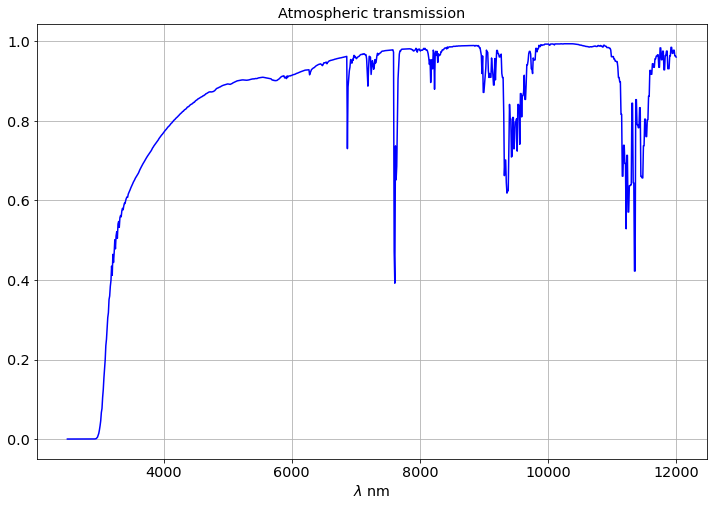

In [11]:
 # 3) atmosphere simulation with libradtran
#--------------------------------------------------



N=1
idx_atm=0
thetransm=transm

# create the passband
bp_atm=S.ArrayBandpass(wl*10,  thetransm, name='atm_transm')

plt.figure()
plt.plot(bp_atm.wave, bp_atm.throughput,'b-')

plt.grid()
plt.title("Atmospheric transmission")
plt.xlabel("$\\lambda$ nm")
plt.show()

In [12]:
# calculate by hand the passband product
final_pb_u=bp_u*bp_atm
final_pb_g=bp_g*bp_atm
final_pb_r=bp_r*bp_atm
final_pb_i=bp_i*bp_atm
final_pb_z=bp_z*bp_atm
final_pb_y=bp_y*bp_atm

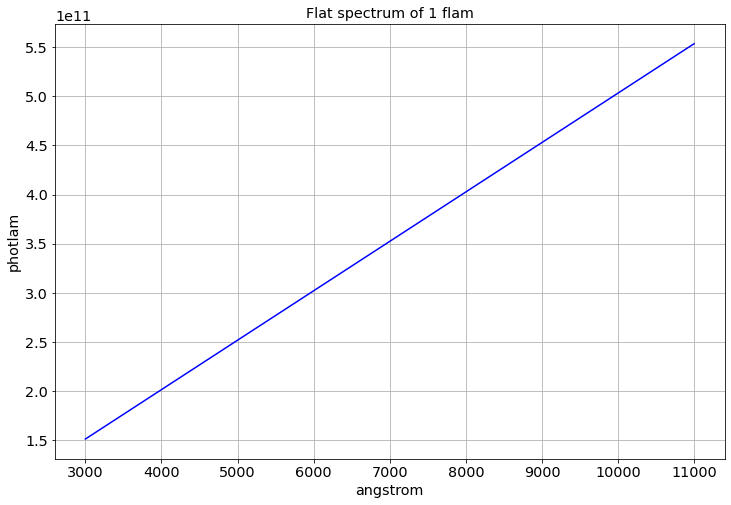

In [13]:
# 6) Convert the SED in PHOTLAM
#------------------------------------
flatsp.convert('photlam')  # before multiplication the spectrum must be transformed in photlam
plt.figure()
plt.plot(flatsp.wave, flatsp.flux,'b-')
plt.xlabel(flatsp.waveunits)
plt.ylabel(flatsp.fluxunits)
plt.title(flatsp.name)
plt.grid()
plt.show()

In [14]:
# 7) Get the true spectrum observed by multiplying the SED in Photlam by the passband
#-------------------------------------------------------------------------------------

final_flux_u=S.Observation(flatsp,final_pb_u)
final_flux_g=S.Observation(flatsp,final_pb_g)
final_flux_r=S.Observation(flatsp,final_pb_r)
final_flux_i=S.Observation(flatsp,final_pb_i)
final_flux_z=S.Observation(flatsp,final_pb_z)
final_flux_y=S.Observation(flatsp,final_pb_y)

((LSST_U * atm_transm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_G * atm_transm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_R * atm_transm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_I * atm_transm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_Z * atm_transm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_Y4 * atm_transm)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


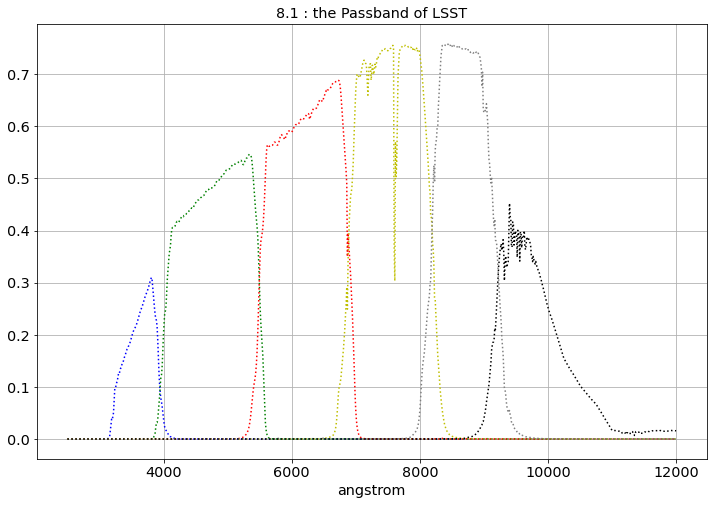

In [15]:
# 8) Show the resulting plots
#------------------------------------------------------------------------------------------

# 8.1) The passband
#--------------------
plt.figure()
plt.plot(final_pb_u.wave,final_pb_u.throughput,'b:')
plt.xlabel(final_pb_u.waveunits.name)
#plt.ylabel(final_pb_u.throughputunits.name)
plt.plot(final_pb_g.wave,final_pb_g.throughput,'g:')
plt.plot(final_pb_r.wave,final_pb_r.throughput,'r:')
plt.plot(final_pb_i.wave,final_pb_i.throughput,'y:')
plt.plot(final_pb_z.wave,final_pb_z.throughput,':',color="grey")
plt.plot(final_pb_y.wave,final_pb_y.throughput,'k:')
plt.title('8.1 : the Passband of LSST')
plt.grid()
plt.show()


# Find the wavelength bins range

In [16]:
def FindBandBoudary(wl,t1,t2,thres=0.01):
    """
    """
    idx_lightpass=np.where(np.logical_and(t1>thres,t2>thres))[0]
    wl_lightpass=wl[idx_lightpass]
    dist=np.abs(t1[idx_lightpass]-t2[idx_lightpass])
    idx_sorted=np.argsort(dist)
    idx_mindist=idx_sorted[0]
    idx_boundary=idx_lightpass[idx_mindist]
    wl_boundary=wl_lightpass[idx_mindist]
    return idx_boundary,wl_boundary
    

## U range

### WL_U_MIN

In [17]:
idx_WL_U_MIN=np.where(final_pb_u.throughput>0.01)[0][0]
WL_U_MIN=final_pb_u.wave[idx_WL_U_MIN]

In [18]:
WL_U_MIN

3170.0

### WL_U_MAX

In [19]:
idx_WL_U_MAX,WL_U_MAX=FindBandBoudary(final_pb_u.wave,final_pb_u.throughput,final_pb_g.throughput)

In [20]:
WL_U_MAX

3950.0

In [21]:
WL_U_MAX-WL_U_MIN

780.0

## G range

In [22]:
idx_WL_G_MIN=idx_WL_U_MAX
WL_G_MIN=WL_U_MAX

In [23]:
idx_WL_G_MAX,WL_G_MAX=FindBandBoudary(final_pb_g.wave,final_pb_g.throughput,final_pb_r.throughput)

In [24]:
WL_G_MAX

5490.0

In [25]:
WL_G_MAX-WL_G_MIN

1540.0

## R range

In [26]:
idx_WL_R_MIN=idx_WL_G_MAX
WL_R_MIN=WL_G_MAX

In [27]:
idx_WL_R_MAX,WL_R_MAX=FindBandBoudary(final_pb_r.wave,final_pb_r.throughput,final_pb_i.throughput)

In [28]:
WL_R_MAX

6890.0

In [29]:
WL_R_MAX-idx_WL_R_MIN

6591.0

## I range

In [30]:
idx_WL_I_MIN=idx_WL_R_MAX
WL_I_MIN=WL_R_MAX

In [31]:
idx_WL_I_MAX,WL_I_MAX=FindBandBoudary(final_pb_i.wave,final_pb_i.throughput,final_pb_z.throughput)

In [32]:
WL_I_MAX-idx_WL_I_MIN

7751.0

## Z range

In [33]:
idx_WL_Z_MIN=idx_WL_I_MAX
WL_Z_MIN=WL_I_MAX

In [34]:
idx_WL_Z_MAX,WL_Z_MAX=FindBandBoudary(final_pb_z.wave,final_pb_z.throughput,final_pb_y.throughput)

In [35]:
WL_Z_MAX-idx_WL_Z_MIN

8651.0

## Y range

In [36]:
idx_WL_Y_MIN=idx_WL_Z_MAX
WL_Y_MIN=WL_Z_MAX

In [37]:
idx_WL_Y_MAX=np.where(final_pb_y.throughput>0.02)[0][-1]
WL_Y_MAX=final_pb_y.wave[idx_WL_Y_MAX]

In [38]:
WL_Y_MAX

10980.0

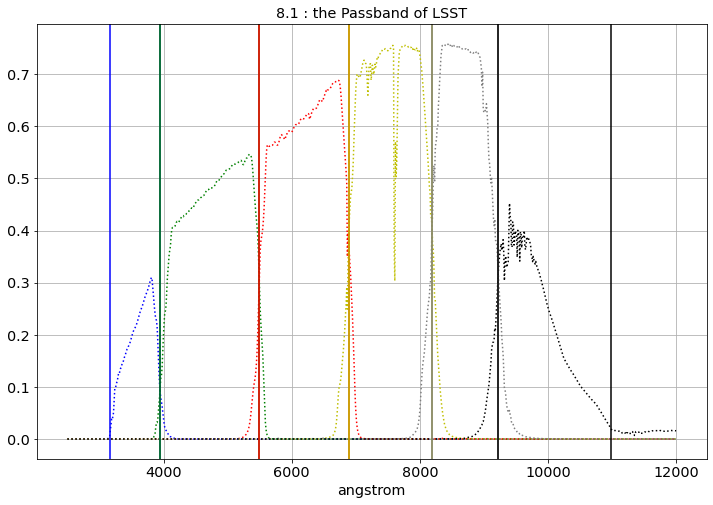

In [39]:
plt.figure()
plt.plot(final_pb_u.wave,final_pb_u.throughput,'b:')
plt.xlabel(final_pb_u.waveunits.name)
#plt.ylabel(final_pb_u.throughputunits.name)
plt.plot(final_pb_g.wave,final_pb_g.throughput,'g:')
plt.plot(final_pb_r.wave,final_pb_r.throughput,'r:')
plt.plot(final_pb_i.wave,final_pb_i.throughput,'y:')
plt.plot(final_pb_z.wave,final_pb_z.throughput,':',color="grey")
plt.plot(final_pb_y.wave,final_pb_y.throughput,'k:')
plt.title('8.1 : the Passband of LSST')
plt.grid()
plt.axvline(x=WL_U_MIN,color='b')
plt.axvline(x=WL_U_MAX,color='b')
plt.axvline(x=WL_G_MIN,color='g')
plt.axvline(x=WL_G_MAX,color='g')
plt.axvline(x=WL_R_MIN,color='r')
plt.axvline(x=WL_R_MAX,color='r')
plt.axvline(x=WL_I_MIN,color='y')
plt.axvline(x=WL_I_MAX,color='y')
plt.axvline(x=WL_Z_MIN,color='grey')
plt.axvline(x=WL_Z_MAX,color='grey')
plt.axvline(x=WL_Y_MIN,color='k')
plt.axvline(x=WL_Y_MAX,color='k')

plt.show()

## Save in file

In [40]:
WL_min= np.array([WL_U_MIN,WL_G_MIN,WL_R_MIN,WL_I_MIN,WL_Z_MIN,WL_Y_MIN])/10.
WL_max= np.array([WL_U_MAX,WL_G_MAX,WL_R_MAX,WL_I_MAX,WL_Z_MAX,WL_Y_MAX])/10.

In [41]:
WL_aver=(WL_max+WL_min)/2.
WL_width=(WL_max-WL_min)

In [42]:
t = Table()
df = pd.DataFrame()

In [43]:
strcol="band"
t[strcol] = ["u","g","r","i","z","y"]
df[strcol] = ["u","g","r","i","z","y"]

In [44]:
strcol="wl_aver"
t[strcol]=WL_aver
df[strcol]=WL_aver
t[strcol].info.format ='4.0f'

In [45]:
strcol="wl_wdth"
t[strcol]=WL_width
df[strcol]=WL_width
t[strcol].info.format ='4.0f'

In [46]:
strcol="wl_min"
t[strcol]=WL_min
df[strcol]=WL_min
t[strcol].info.format ='4.0f'

In [47]:
strcol="wl_max"
t[strcol]=WL_max
df[strcol]=WL_max
t[strcol].info.format ='4.0f'

In [48]:
df

,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356.0,78.0,317.0,395.0
1,g,472.0,154.0,395.0,549.0
2,r,619.0,140.0,549.0,689.0
3,i,754.0,130.0,689.0,819.0
4,z,870.5,103.0,819.0,922.0
5,y,1010.0,176.0,922.0,1098.0


In [49]:
t.show_in_notebook()

idx,band,wl_aver,wl_wdth,wl_min,wl_max
0,u,356,78,317,395
1,g,472,154,395,549
2,r,619,140,549,689
3,i,754,130,689,819
4,z,870,103,819,922
5,y,1010,176,922,1098


In [50]:
filename_out=file_out_basename+".fits"
t.write(filename_out, overwrite=True)


In [51]:
filename_out=file_out_basename+".csv"
df.to_csv(filename_out)

In [52]:
filename_out


'WaveLengthBins.csv'